In [79]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread_collection
import cv2
from PIL import Image

In [202]:
def compute_within_class(m,X):
    Sw = np.zeros((115*97,115*97))
    for i in range(9*15):
        temp = X[i]-m[i//9]
        Sw += np.dot(temp.T,temp)
    return Sw

In [203]:
def compute_between_class(m,M):
    Sb = np.zeros((115*97,115*97))
    for i in range(15):
        temp = m[i]-M
        Sb += np.dot(temp.T,temp)*9
    return Sb

In [172]:
def compute_mean(X):
    m = np.zeros((15,115*97))
    M = np.zeros(115*97)
    for i in range(15):
        m[i] = np.mean(X[i*9:(i+1)*9,:],axis=0)
    M = np.mean(m,axis=0)
    return m,M

In [130]:
def im_concatenate(im):
    res = np.concatenate((im[:,0].reshape((115,97)),
                          im[:,1].reshape((115,97)),
                          im[:,2].reshape((115,97)),
                          im[:,3].reshape((115,97)),
                          im[:,4].reshape((115,97))),axis=1)
    for i in range(1,5):
        temp = np.concatenate((im[:,i*5+0].reshape((115,97)),
                               im[:,i*5+1].reshape((115,97)),
                               im[:,i*5+2].reshape((115,97)),
                               im[:,i*5+3].reshape((115,97)),
                               im[:,i*5+4].reshape((115,97))),axis=1)
        res = np.concatenate((res,temp),axis=0)
    return res

In [45]:
im_shape = (231,195)
train_im = np.array(imread_collection('Yale_Face_Database/Training/*.pgm'))
test_im = np.array(imread_collection('Yale_Face_Database/Testing/*.pgm'))
train = np.zeros((train_im.shape[0],115*97))
test = np.zeros((test_im.shape[0],115*97))

In [47]:
for i in range(train_im.shape[0]):
    train[i] = cv2.resize(train_im[i],(97,115),cv2.INTER_CUBIC).reshape(-1,97*115)
for i in range(test_im.shape[0]):
    test[i] = cv2.resize(test_im[i],(97,115),cv2.INTER_CUBIC).reshape(-1,97*115)

In [113]:
train_label = []
test_label = []
for i in range(1,16):
    train_label.append([i]*9)
    test_label.append([i]*2)
train_label = np.array(train_label).reshape(-1)
test_label = np.array(test_label).reshape(-1)

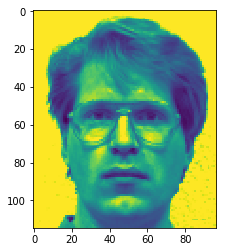

In [48]:
plt.imshow(test[0].reshape(115,97))

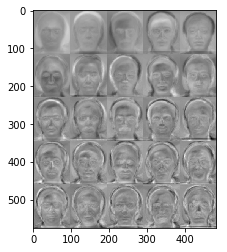

In [131]:
# PCA
cov = np.cov(train.transpose())
eigen_values, eigen_vectors = np.linalg.eigh(cov)
sorted_eigen_vectors = eigen_vectors[:,eigen_values.argsort()[::-1]]
plt.imshow(im_concatenate(sorted_eigen_vectors[:,:25]),cmap='binary')
plt.imsave('eigenface',im_concatenate(sorted_eigen_vectors[:,:25]),cmap='binary')

In [ ]:
# LDA
m,M = compute_mean(train)
Sw = compute_within_class(m,train)
Sb = compute_between_class(m,M)
eigen_values2, eigen_vectors2 = np.linalg.eig(np.dot(np.linalg.pinv(Sw),Sb)) # Use pseudo-inverse since Sw invertible
sorted_eigen_vectors2 = eigen_vectors2[:,eigen_values2.argsort()[::-1]]

In [ ]:
plt.imshow(im_concatenate(sorted_eigen_vectors2[:,:25]),cmap='binary')
plt.imsave('fisherface',im_concatenate(sorted_eigen_vectors[:,:25]),cmap='binary')